In [1]:
# get the essentials
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# read the image file
image = cv2.imread('dataset/0022.jpg')
original_image = image.copy()

In [3]:
#preprocess
image = cv2.GaussianBlur(image, (5, 5), 0)
image = cv2.dilate(image, None, iterations = 5)
image = cv2.erode(image, None, iterations = 5)

In [4]:
# specify colour boundaries
page_min = np.array([157, 171, 185])
page_max = np.array([255, 255, 255])

In [5]:
# identify areas
mask = cv2.inRange(image, page_min, page_max)

# remove unwanted regions
binary_image = cv2.bitwise_and(image, image, mask = mask)

In [6]:
# convert image to GRAY
binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)

# find image shape
print(binary_image.shape)

(1368, 1530)


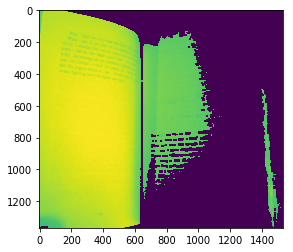

In [7]:
plt.imshow(binary_image)

In [8]:
# find contours
contours = cv2.findContours(binary_image.copy(), cv2.RETR_EXTERNAL,
                           cv2.CHAIN_APPROX_SIMPLE)

# yeah, the original contours is recursive
contours = contours[1]

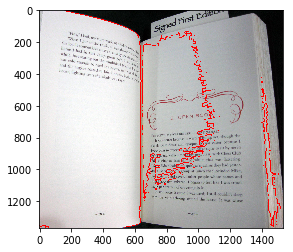

In [9]:
# draw all contours
output_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
output_image = cv2.drawContours(output_image, contours, -1, (255, 0, 0), 3)
plt.imshow(output_image)

In [10]:
# find largest four sided object
sorted_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    
    if len(approx) == 4:
        break

In [11]:
# finds rectangle covering the landmark
bounding_box = cv2.minAreaRect(contour)

# reshape the contours
page_contour = approx.reshape(4, 2)

In [12]:
# transform image
def four_point_transform(image, points):
    rectangle = np.zeros((4, 2), dtype = 'float32')
    sum_of_points = points.sum(axis = 1)
    rectangle[0] = points[np.argmin(sum_of_points)]
    rectangle[2] = points[np.argmax(sum_of_points)]

    difference = np.diff(points, axis = 1)
    rectangle[1] = points[np.argmin(difference)]
    rectangle[3] = points[np.argmax(difference)]
    (tl, tr, br, bl) = rectangle

    width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_a), int(width_b))

    height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_b = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_a), int(height_b))

    destination_points = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype = 'float32')

    transform_matrix = cv2.getPerspectiveTransform(rectangle,
        destination_points)
    
    warped_image = cv2.warpPerspective(image, transform_matrix,
        (max_width, max_height))

    return warped_image

transformed_image = four_point_transform(image, page_contour)

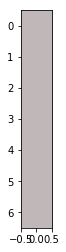

In [13]:
plt.imshow(transformed_image)